In [1]:
import matplotlib.pyplot as plt
from icecream import ic
import time
from collections import OrderedDict

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from copy import deepcopy

from src.utils.audio_utils import playAudio
from src.model import get_magnet_model, MAGNET
from src.preprocess_ops import PreProOps
from src.music_bench import (
    MAX_SEC,
    shuffle_preserve_order,
    QCODING_LEN,
)
from train import PreProDataset, MagnetTrainer
from src.utils.lr_scheduler import CosineDecayWithWarmup
from src.music_bench import AUDIO_TXT_PATH, ioPathTextDs

torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from train import tonfig
DEVICE = torch.device("cuda")

In [2]:
ctx = (
        torch.autocast(
                device_type="cuda" if "cuda" in DEVICE.type else "cpu",
                dtype={"bfloat16": torch.bfloat16,
                       "float16" : torch.float16}[tonfig.dtype]
        )
    )

In [3]:
preprocess_ops = PreProOps(
    max_sec=QCODING_LEN,
    print_info=True,
    device=DEVICE.type,
    compile=False,
    autocast=ctx
)

/home/vvy/Desktop/repos/MAGNeT/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



Number of Parameters in Encodec Model: 14.85181 Million Parameters


Number of Parameters in T5 Model (google-t5/t5-small): 35.330816 Million Parameters



In [5]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[100:101],
    texts=y_train[100:101],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 311,  457,  311,  ..., 1024, 1024, 1024],
           [ 743,  388,  304,  ..., 1024, 1024, 1024],
           [ 838,  538,  331,  ..., 1024, 1024, 1024],
           [ 407,  171,  206,  ..., 1024, 1024, 1024]],
  
          [[   8,  846,  846,  ...,  392,  392,  903],
           [ 491,  409,  505,  ...,  479,  985,  737],
           [ 888,  331,   63,  ...,  748,  609,  112],
           [ 636,  971,  623,  ...,  628,  985,  275]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [6]:
magnet_model:MAGNET = get_magnet_model(compile=False).to(DEVICE)
debug_input = next(train_iterator)

# Test Training:

# Try Overfitting lil batch

In [7]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[100:101],
    texts=y_train[100:101],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 311,  457,  311,  ..., 1024, 1024, 1024],
           [ 743,  388,  304,  ..., 1024, 1024, 1024],
           [ 838,  538,  331,  ..., 1024, 1024, 1024],
           [ 407,  171,  206,  ..., 1024, 1024, 1024]],
  
          [[   8,  846,  846,  ...,  392,  392,  903],
           [ 491,  409,  505,  ...,  479,  985,  737],
           [ 888,  331,   63,  ...,  748,  609,  112],
           [ 636,  971,  623,  ...,  628,  985,  275]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [8]:
print(sum(p.numel() for p in magnet_model.parameters() if p.requires_grad)/1e6, "Million Parameters")

37.833728 Million Parameters


In [9]:
magnet_trainer = MagnetTrainer(
    magnet_model=magnet_model,
    preprocess_ops=preprocess_ops,
    config=tonfig
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=tonfig.warmup_steps,
    max_learning_rate=tonfig.max_learning_rate,
    decay_steps=tonfig.decay_steps,
    min_learning_rate=tonfig.min_learning_rate
)

scaler = torch.cuda.amp.GradScaler(enabled=(tonfig.dtype=="float16"))

optimizer = magnet_model.configure_optimizers(
    weight_decay=tonfig.weight_decay,
    learning_rate=5e-4,
    betas=(tonfig.beta1, tonfig.beta2),
    device_type="cuda" if "cuda" in DEVICE.type else "cpu"
)

@torch.no_grad()
def update_ema(ema_model:MAGNET, model:MAGNET, decay:float):
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        # ema = decay*ema + (1-decay)*no_ema
        ema_params[name].mul_(decay).add_(param.data, alpha=1-decay)

def requires_grad(model:nn.Module, requires_grad:bool):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [10]:
ema = deepcopy(magnet_model).to(DEVICE) # sampling with ema model
requires_grad(ema, requires_grad=False)
magnet_model.train()
ema.eval()
update_ema(ema, magnet_model, decay=0.0) # ema_model weights are in sync with magnet_model

In [11]:
losses, accuracies = [], []
def test_train():
    audio_input, cond_text = next(train_iterator)

    print("Training about to start...")
    t0 = time.time()
    for step in range(0, 2000):
        # set learning rate for all params
        lr = 5e-4
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # gradient accumulation step
        for mini_step in range(tonfig.num_grad_accumalation_steps):
            with ctx:
                loss, accuracy = magnet_trainer.mini_train_step(
                    audio_input=audio_input, cond_str=cond_text
                )
                loss /= tonfig.num_grad_accumalation_steps
                # async prefetch immediately
                audio_input, cond_text = next(train_iterator)

            # keeps on scaling and adding gradients when calling backward
            scaler.scale(loss).backward()

        if tonfig.clipnorm is not None:
            # unscale the gradients
            scaler.unscale_(optimizer)
            # clips gradients in-place to grad norm
            grad_norm = nn.utils.clip_grad_norm_(magnet_model.parameters(), max_norm=tonfig.clipnorm)

        # calls unscale to the optimizer unless already called, checks for infs and nans as a part of unscale_
        # calls optimizer.step on unscaled grads if no infs and nans else optimizer.step is skipped
        scaler.step(optimizer)
        # Update the scale factor
        scaler.update()

        # flush grads to save memory
        optimizer.zero_grad(set_to_none=True)

        # update ema model
        update_ema(ema, magnet_model, decay=tonfig.ema_momentum)

        # some logging
        t1 = time.time()
        dt = t1-t0
        t0 = t1
        if step % tonfig.log_interval == 0:
            # multiply as loss was scaled for gradient accumulation
            lossf = loss.item() * tonfig.num_grad_accumalation_steps
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || Masked Accuracy: {accuracy[1]:.4f} | Accuracy: {accuracy[0]:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
            )
            losses.append(lossf); accuracies.append(accuracy)
    return losses, accuracies

losses, accuracies = test_train() # Clear Output

Training about to start...
| Step: 0 || Loss: 6.9307 || Masked Accuracy: 0.0010 | Accuracy: 0.0015 || LR: 5.000000e-04 || dt: 347.36ms |
| Step: 1 || Loss: 6.7515 || Masked Accuracy: 0.1337 | Accuracy: 0.0400 || LR: 5.000000e-04 || dt: 118.41ms |
| Step: 2 || Loss: 6.9328 || Masked Accuracy: 0.0008 | Accuracy: 0.0418 || LR: 5.000000e-04 || dt: 131.40ms |
| Step: 3 || Loss: 6.8058 || Masked Accuracy: 0.0101 | Accuracy: 0.0148 || LR: 5.000000e-04 || dt: 125.70ms |
| Step: 4 || Loss: 6.7079 || Masked Accuracy: 0.0036 | Accuracy: 0.0108 || LR: 5.000000e-04 || dt: 125.70ms |
| Step: 5 || Loss: 5.9024 || Masked Accuracy: 0.0152 | Accuracy: 0.0072 || LR: 5.000000e-04 || dt: 116.44ms |
| Step: 6 || Loss: 6.4340 || Masked Accuracy: 0.0097 | Accuracy: 0.0137 || LR: 5.000000e-04 || dt: 118.23ms |
| Step: 7 || Loss: 5.6540 || Masked Accuracy: 0.0628 | Accuracy: 0.0208 || LR: 5.000000e-04 || dt: 120.05ms |
| Step: 8 || Loss: 6.4452 || Masked Accuracy: 0.0530 | Accuracy: 0.0833 || LR: 5.000000e-04 |

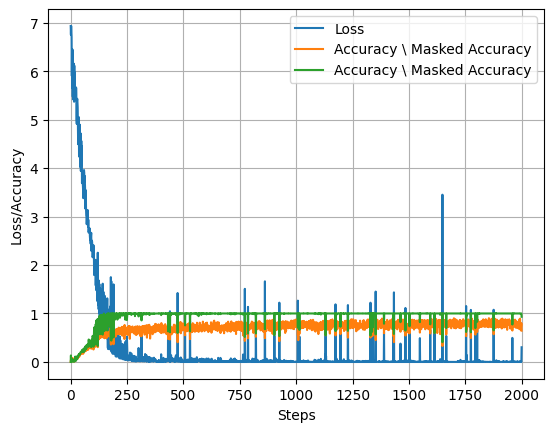

In [12]:
plt.plot(losses, label="Loss")
plt.plot(accuracies, label="Accuracy \ Masked Accuracy")
plt.grid(True)
plt.ylabel("Loss/Accuracy")
plt.xlabel("Steps")
plt.legend()
plt.show()

In [13]:
min(losses), max(accuracies), losses.index(min(losses)), accuracies.index(max(accuracies)), losses[1000:].index(max(losses[1000:]))+1000, max(losses[1000:])

(4.4201538003108e-05,
 (0.9025000333786011, 1.0),
 1709,
 1854,
 1648,
 3.450568914413452)

# Test Generate

In [14]:
debug_input = next(train_iterator)
debug_input

({'qcode': tensor([[[ 311,  457,  311,  ..., 1024, 1024, 1024],
           [ 743,  388,  304,  ..., 1024, 1024, 1024],
           [ 838,  538,  331,  ..., 1024, 1024, 1024],
           [ 407,  171,  206,  ..., 1024, 1024, 1024]],
  
          [[   8,  846,  846,  ...,  392,  392,  903],
           [ 491,  409,  505,  ...,  479,  985,  737],
           [ 888,  331,   63,  ...,  748,  609,  112],
           [ 636,  971,  623,  ...,  628,  985,  275]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [15]:
magnet_model.eval()
gen_tok = magnet_model.generate(
    prompt=debug_input[1],
    preprocess_ops=preprocess_ops,
    device=DEVICE,
    top_p=0.9,
    decoding_steps=[20, 10, 10, 10]
) # (2, 4, 750)
gen_wav = preprocess_ops.getAudioFromCodings(gen_tok) # (2, 1, 240000)
playAudio(tensor=gen_wav[0].squeeze())
playAudio(tensor=gen_wav[1].squeeze())

Playing WAVE '/tmp/tmpbb0ng9tj.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono
Playing WAVE '/tmp/tmp8eahogfu.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono


In [16]:
ema.eval()
gen_tok = ema.generate(
    prompt=debug_input[1],
    preprocess_ops=preprocess_ops,
    device=DEVICE,
    top_p=0.9,
    decoding_steps=[20, 10, 10, 10]
)
gen_wav = preprocess_ops.getAudioFromCodings(gen_tok)
playAudio(tensor=gen_wav[0].squeeze())
playAudio(tensor=gen_wav[1].squeeze())

Playing WAVE '/tmp/tmp5vubbhlv.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono
Playing WAVE '/tmp/tmp4xi_w8sj.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono


In [17]:
# original, from dataset
gen_tok = debug_input[0]["qcode"][1][None]
gen_wav = preprocess_ops.getAudioFromCodings(gen_tok)
playAudio(tensor=gen_wav[0].squeeze())

Playing WAVE '/tmp/tmp9k4r6f7v.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono


# Nothing...

In [1]:
import matplotlib.pyplot as plt
import math

In [14]:
def plot(num_decoding_steps):
    func = lambda t: math.cos((math.pi * t)/(2*num_decoding_steps))
    plt.plot(list(range(num_decoding_steps)), [func(t) for t in range(num_decoding_steps)], label="mask_p")
    plt.xlabel("Decoding Steps")
    plt.ylabel("Mask Probability (in inference)")
    plt.grid(True)
    plt.legend()
    plt.show()

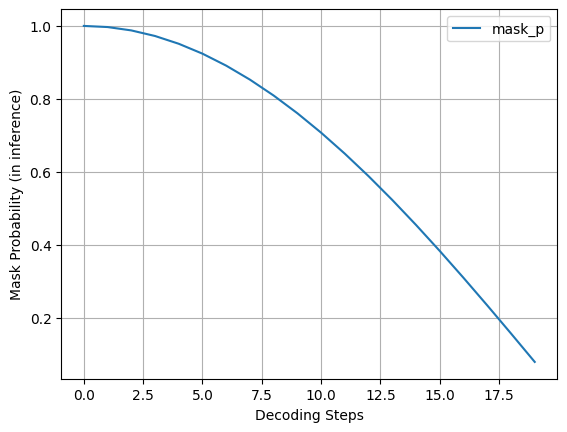

In [15]:
plot(20)

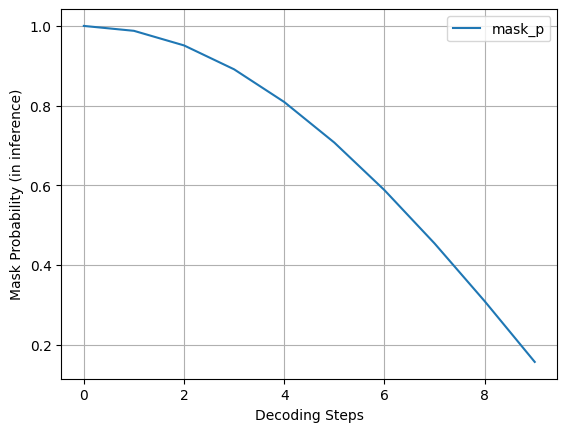

In [16]:
plot(10)